In [1]:
%matplotlib inline

In [2]:
import os
import sys

In [3]:
print sys.version

2.7.14 (default, Feb 15 2018, 20:22:28) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

In [6]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score

In [7]:
from utils import rmsle, rmsle1m

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [8]:
from dataload import load_features

### Make RMSLE scorers

In [9]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
rmsle_scorer_1m = make_scorer(rmsle1m, greater_is_better=False)

### Dictionary of RMSLE results

In [10]:
rmsle_results_bg = {}
rmsle_results_e0 = {}

### Load basic data

In [11]:
DATA_DIR = './data'

In [12]:
train, test = load_features(DATA_DIR, with_ext=False, with_geo=False)

### Build basic train and test data sets

In [13]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'cellvol',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'cellvol'], axis=1)

In [14]:
# Use log1p of energies to correct for skew
y_bg_train = train['bandgap']
y_e0_train = np.log1p(train['E0'])

In [15]:
# One-hot encode spacegroup_natoms
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

### Test different models

#### Output predictions (Mean model)

In [16]:
est_bg = DummyRegressor(strategy='mean')
est_e0 = DummyRegressor(strategy='mean')
est_bg.fit(X_train, y_bg_train)
est_e0.fit(X_train, y_e0_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [17]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [19]:
rmsle_results_bg['mean_model'] = err_bg
rmsle_results_e0['mean_model'] = err_e0

In [20]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.334607448934, RMSLE E0: 0.0865187157453, RMSLE AVG: 0.21056308234


#### Output predictions (Basic model)

In [21]:
pa_bg = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 120,
         'max_depth': 5,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 108,
         'max_depth': 5,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [22]:
# Estimator pipeline
est_bg = Pipeline([
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [23]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [24]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=108,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [25]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [26]:
rmsle_results_bg['basic_model'] = err_bg
rmsle_results_e0['basic_model'] = err_e0

In [27]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.088773338009, RMSLE E0: 0.0332685633877, RMSLE AVG: 0.0610209506984


### Load extra data

In [28]:
train, test = load_features(DATA_DIR, with_ext=True, with_geo=False)

### Build extra train and test data sets

In [29]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass'], axis=1)

In [30]:
# Use log1p of energies to correct for skew
y_bg_train = train['bandgap']
y_e0_train = np.log1p(train['E0'])

In [31]:
# One-hot encode spacegroup_natoms
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

### Test different models

#### Output predictions (With ext model)

In [32]:
pa_bg = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.01,          # L1 regularization term on weights
         'n_estimators': 290,
         'max_depth': 3,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 150,
         'max_depth': 4,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [33]:
# Estimator pipeline
est_bg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [34]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=290,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [35]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [36]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [37]:
rmsle_results_bg['with_ext_model'] = err_bg
rmsle_results_e0['with_ext_model'] = err_e0

In [38]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.087336312961, RMSLE E0: 0.0328474454784, RMSLE AVG: 0.0600918792197


### Load extra data and geo data

In [39]:
train, test = load_features(DATA_DIR, with_ext=True, with_geo=True)

### Build extra and geo train and test data sets

In [40]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'o_cnt', 'cellvol', 'o_fraction', 'avg_mass'], axis=1)

In [41]:
# Use log1p of energies to correct for skew
y_bg_train = train['bandgap']
y_e0_train = np.log1p(train['E0'])

In [42]:
# One-hot encode spacegroup_natoms
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

### Test different models

#### Output predictions (With ext and geo model, no PCA)

In [43]:
pa_bg = {'learning_rate': 0.02,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.05,          # L1 regularization term on weights
         'n_estimators': 600,
         'max_depth': 3,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 500,
         'max_depth': 4,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [44]:
# Estimator pipeline
est_bg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [45]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [46]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [47]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [48]:
rmsle_results_bg['with_ext_geo_model'] = err_bg
rmsle_results_e0['with_ext_geo_model'] = err_e0

In [49]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.0873208862721, RMSLE E0: 0.0286716670854, RMSLE AVG: 0.0579962766787


#### Output predictions (With ext and geo model, with PCA)

In [50]:
pa_bg = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.05,          # L1 regularization term on weights
         'n_estimators': 700,
         'max_depth': 3,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 800,
         'max_depth': 4,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [51]:
# Estimator pipeline
est_bg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=32, random_state=42)),
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=58, random_state=42)),
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [52]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=32, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample...     reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [53]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=58, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample...      reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [54]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [55]:
rmsle_results_bg['with_ext_geo_pca_model'] = err_bg
rmsle_results_e0['with_ext_geo_pca_model'] = err_e0

In [56]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.0998628063497, RMSLE E0: 0.0339059468051, RMSLE AVG: 0.0668843765774


#### Output predictions (With ext and geo model, with Kernal PCA)

In [57]:
pa_bg = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.05,          # L1 regularization term on weights
         'n_estimators': 700,
         'max_depth': 3,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}
pa_e0 = {'learning_rate': 0.05,      # Step size shrinkage used in update (Learning rate)
         'reg_alpha': 0.10,          # L1 regularization term on weights
         'n_estimators': 800,
         'max_depth': 4,
         'subsample': 1,
         'colsample_bytree': 0.90,
         'colsample_bylevel': 0.90,
         'silent': True,
         'random_state': 42,
         'objective': 'reg:linear'}

In [58]:
# Estimator pipeline
est_bg = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA(kernel='poly', fit_inverse_transform=True, n_components=32, random_state=42)),
    ('xgbreg', XGBRegressor(**pa_bg)),
])
est_e0 = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA(kernel='poly', fit_inverse_transform=True, n_components=58, random_state=42)),
    ('xgbreg', XGBRegressor(**pa_e0)),
])

In [59]:
est_bg.fit(X_train, y_bg_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=None, kernel='poly',
     kernel_params=None, max_iter=None, n_components=32, n_jobs=1,
     random_s...     reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [60]:
est_e0.fit(X_train, y_e0_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=None, kernel='poly',
     kernel_params=None, max_iter=None, n_components=58, n_jobs=1,
     random_s...      reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [61]:
err_bg = -cross_val_score(est_bg, X_train, y_bg_train, scoring=rmsle_scorer, cv=5).mean()
err_e0 = -cross_val_score(est_e0, X_train, y_e0_train, scoring=rmsle_scorer_1m, cv=5).mean()

In [62]:
# 5-fold CV Scores
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.104818336766, RMSLE E0: 0.0368459313898, RMSLE AVG: 0.070832134078


### Plotting results

In [150]:
models = ['with_ext_geo_pca_model', 'with_ext_geo_model', 'with_ext_model', 'basic_model', 'mean_model']

In [154]:
rmsle_bg = [rmsle_results_bg[i] for i in models]
rmsle_e0 = [rmsle_results_e0[i] for i in models]

In [155]:
df = pd.DataFrame(map(list, zip(*[models, rmsle_bg, rmsle_e0])), columns=['model', 'bandgap', 'E0'])

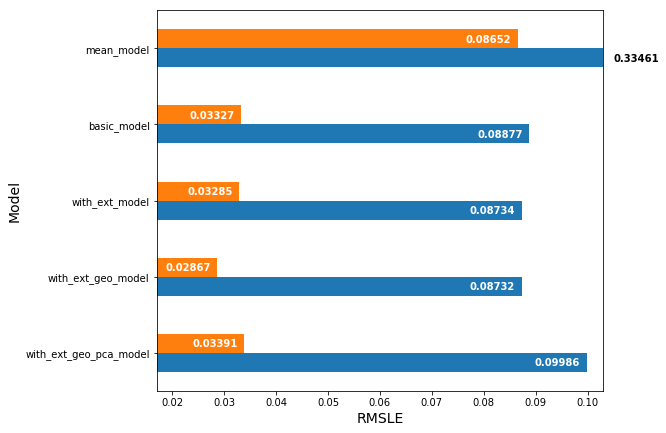

In [167]:
ax = df.plot.barh(x='model',
             figsize=(8, 7), 
             xlim=[0.017, 0.103],
             legend=False)
plt.xlabel('RMSLE', fontsize=14)
plt.ylabel('Model', fontsize=14)
for i in range(len(df)):
    ax.text(df.E0.iloc[i] - 0.01,
            i + 0.075, str(round(df.E0.iloc[i], 5)),
            color='white', fontweight='bold')
    if df.bandgap.iloc[i] - 0.01 < 0.105:
        ax.text(df.bandgap.iloc[i] - 0.01,
                i-0.175, str(round(df.bandgap.iloc[i], 5)),
                color='white', fontweight='bold')
    else:
        ax.text(0.105,
                i-0.175, str(round(df.bandgap.iloc[i], 5)),
                color='black', fontweight='bold')